<a href="https://colab.research.google.com/github/claredavies/AutomaticLearning/blob/main/Assignment1/SupervisedLearningAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import numpy as np
from google.colab import files
import pandas as pd
from matplotlib import pyplot as plt
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_string_dtype
import re
import socket
from scipy.stats import zscore
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import SCORERS
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import hstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from numpy.ma.core import negative

In [2]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.set_option('display.max_rows', None)

# Read in Files

In [3]:
!git clone https://github.com/claredavies/AutomaticLearning

Cloning into 'AutomaticLearning'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 103 (delta 34), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (103/103), 1.52 MiB | 4.82 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [4]:
%ls

AutomaticLearning/  sample_data/


In [5]:
%cd AutomaticLearning/Assignment1/Data/

/content/AutomaticLearning/Assignment1/Data


In [6]:
df = pd.read_csv('ds_03.csv')
df.head(3)

,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,...,V29,V30,V31,V32,V33,V34,V35,V36,class,target
0,8.82,3.50,10.88,41.70,10.17,NaN,4.18,16.42,3.75,12.87,...,29.30,16.2,10.21,3.84,38.06,NaN,8.47,7.68,1,0.3911
1,12.49,5.08,13.39,35.88,7.02,11.0,6.92,15.35,4.99,6.88,...,68.45,NaN,16.62,4.61,NaN,33.78,9.05,6.12,4,0.4179
2,14.07,3.99,10.87,27.80,9.82,10.6,4.10,NaN,3.34,11.65,...,50.44,NaN,16.84,3.16,39.22,29.64,10.30,11.22,4,0.4090


# Cleaning Functions

In [7]:
def return_columns_missing_values(df):
  return df.columns[df.isnull().any()]

In [8]:
def missing_value_column_percentage(dataframe, column_name):
  percent_missing = dataframe.loc[:, column_name].isnull().sum() * 100 / len(dataframe)
  return percent_missing

In [9]:
def checkNumberMissingValuesInRowAboveThreshold(dataframe, threshold):
  listMissingValuesAboveThresh = []
  for i in range(len(dataframe.index)):
    resultMissing = dataframe.iloc[i].isnull().sum()
    index = dataframe.iloc[i].index
    if resultMissing > threshold:
      listMissingValuesAboveThresh.append(i)
  # print(listMissingValuesAboveThresh)
  df = dataframe.drop(listMissingValuesAboveThresh, inplace=False)
  return df

In [10]:
def checkZScoreHigherThreshold(dataframe, threshold):
  listOverThreshold = []
  dfZValues = dataframe.apply(stats.zscore)
  for col in dataframe.columns:
    if col != "class":
      found = dfZValues.index[dfZValues[col]>threshold].tolist()
      listOverThreshold = listOverThreshold + found
  listOverThreshold = list(dict.fromkeys(listOverThreshold))
  # print(listOverThreshold)
  df = dataframe.drop(listOverThreshold, inplace=False)
  return df

# T1.a

ai. samples with more than 4 missing feature values have to be dropped,

In [11]:
dfClean = checkNumberMissingValuesInRowAboveThreshold(df, 4)

aii. the remaining missing values have to be filled using the average value, and

In [12]:
dfClean = dfClean.fillna(dfClean.mean())

aiii. samples with at least one feature value with a z-score higher than 3 (i.e. an outlier) have to be discarded.

In [13]:
dfClean = checkZScoreHigherThreshold(dfClean, 3)

# T1.b

It is suspected that not all 36 features are needed for a successful classification. To remove unnecessary
dimensions and reduce the computation time, it is decided to keep only those features that account for
up to 95% of the variance of the data.

In [14]:
X = dfClean.drop("class", axis=1)
Y = dfClean['class']

In [15]:
def findWantedKforPCA(dataframe, threshold):
  for i in range(len(dataframe.columns)):
    pca = PCA(n_components=i)
    principalComponents1 = pca.fit_transform(dataframe)
    variance = sum(pca.explained_variance_ratio_)
    if variance > threshold:
      return i
  print("unable to met threshold")
  return 0

In [16]:
n = findWantedKforPCA(X, 0.95)
print("number of features needed for 95% variance:  " + str(n))
pca = PCA(n_components=n)
principalComponents = pca.fit_transform(X)

pca.explained_variance_ratio_
print(sum(pca.explained_variance_ratio_))

number of features needed for 95% variance:  14
0.9500589973517074


In [17]:
Xpca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3', 'principal component 4','principal component 5','principal component 6','principal component 7','principal component 8','principal component 9','principal component 10',
                          'principal component 11','principal component 12','principal component 13', 'principal component 14'])

Xpca.tail()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,principal component 11,principal component 12,principal component 13,principal component 14
918,10.517648,8.849201,-10.580086,16.411439,7.663826,-15.744594,8.478717,-9.244069,-0.783211,-0.249704,2.251750,-4.002827,5.772036,1.415050
919,3.628870,0.804786,-12.244010,2.127585,14.357679,-1.606728,8.616712,13.178788,-1.285941,-1.847388,7.393562,-1.256534,0.891301,-2.310147
920,-38.292032,35.411712,-1.974346,-8.600256,-1.253000,-4.488746,-7.452547,7.342710,4.758290,-9.356941,1.554263,3.106700,-2.925432,-0.098135
921,41.345596,-17.492213,-5.649815,2.941931,-2.678740,3.914277,-11.742453,0.371266,-16.114396,-13.910383,-3.600531,-1.382699,-4.090317,0.300873
922,-19.948580,13.821654,-0.024228,-13.221582,0.761577,8.282948,2.931496,-9.340230,16.107986,5.192714,-2.260380,4.466083,0.201708,0.346445


# T1.c

Normalize the data using mu-sigma standardization.

In [18]:
standardizer = StandardScaler()
X = standardizer.fit_transform(Xpca)

In [19]:
X = pd.DataFrame(data = X
             , columns = ['principal component 1', 'principal component 2','principal component 3', 'principal component 4','principal component 5','principal component 6','principal component 7','principal component 8','principal component 9','principal component 10',
                          'principal component 11','principal component 12','principal component 13', 'principal component 14'])

In [20]:
print(X.head())

   principal component 1  principal component 2  principal component 3  \
0               0.313434               0.841294              -0.472641   
1              -0.315836              -0.262807               1.914726   
2              -0.158084              -0.351200               0.467123   
3               0.569296              -0.257306               0.758210   
4              -0.866370               0.140033               0.502157   

   principal component 4  principal component 5  principal component 6  \
0              -0.230768               0.447245              -0.688859   
1               0.610557               0.281744              -0.229400   
2              -0.422589              -0.566503              -0.164481   
3               0.328537               1.860091               0.567699   
4               0.998485              -1.935781              -1.256409   

   principal component 7  principal component 8  principal component 9  \
0              -0.942207            

# T1.d

Finally, calculate the imbalance ratio (IR) of the dataset

In [21]:
result = Y.value_counts()

In [22]:
print(result)

4    240
1    215
0    161
5    152
3     80
2     75
Name: class, dtype: int64


In [23]:
IR = max(result)/min(result)
print("Imbalance ratio:  " + str(IR))

Imbalance ratio:  3.2


# T2.a -tuning

It is believed that maybe a single classifier is not going to be able to solve the problem satisfactorily and hence
it is decided to consider several models:
1) Gaussian Naive Bayes (GNB)
2) Logistic Regression (LR)
3) Decision Tree (DT)
4) Support Vector Machine (SVM)

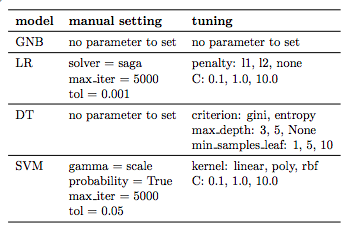

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2, random_state =0)

LR Grid Search - penalty l1 not explored as not supported by manual setting of solver=*saga*

In [25]:
logistic = linear_model.LogisticRegression()
C = [0.1, 1.0, 10.0]
penalty = ["none", "l2"]
hyperparameters = dict(C=C, penalty=penalty)

In [26]:
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X, Y)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the

In [27]:
print("Best Penalty:", best_model.best_estimator_.get_params()["penalty"])
print("Best C:", best_model.best_estimator_.get_params()["C"])

Best Penalty: l2
Best C: 1.0


DT - Grid Search

In [28]:
dt = DecisionTreeClassifier()
criterion = ["gini", "entropy"]
max_depth = [3, 5, None]
min_samples_leaf = [1, 5, 10]
hyperparameters = dict(criterion=criterion, max_depth=max_depth, 
                       min_samples_leaf=min_samples_leaf)

In [29]:
clf = GridSearchCV(dt, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X, Y)

In [30]:
print("Best criterion:", best_model.best_estimator_.get_params()["criterion"])
print("Best max_depth:", best_model.best_estimator_.get_params()["max_depth"])
print("Best min_samples_leaf:", best_model.best_estimator_.get_params()["min_samples_leaf"])

Best criterion: entropy
Best max_depth: None
Best min_samples_leaf: 10


SVM - Grid Search

In [31]:
svm = SVC()
kernel = ["linear", "poly", "rbf"]
C = [0.1, 1.0, 10.0]
hyperparameters = dict(kernel = kernel, C = C)

In [32]:
clf = GridSearchCV(svm, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X, Y)

In [33]:
print("Best C:", best_model.best_estimator_.get_params()["C"])
print("Best kernel:", best_model.best_estimator_.get_params()["kernel"])

Best C: 1.0
Best kernel: rbf


# T2.b & c

In [40]:
def getModelsDict():
 # define the base modelsDict
 # define the voting ensemble
  modelsDict = dict()

  modelsDict['GNB'] = GaussianNB()
  modelsDict['LR'] = LogisticRegression(C = 1, penalty = 'l2', solver ='saga', max_iter = 5000, tol = 0.001)
  modelsDict['DT'] = DecisionTreeClassifier(criterion= "entropy", max_depth = None,  min_samples_leaf= 1)
  modelsDict['SVM'] = SVC(C= 1.0, kernel= "rbf", gamma = "scale", probability = True, max_iter = 5000, tol = 0.05)

  return modelsDict

In [41]:
def getModelsList():
  modelsList = list()
  modelsList.append(('GNB', GaussianNB()))
  modelsList.append(('LR', LogisticRegression(C = 1, penalty = 'l2', solver ='saga', max_iter = 5000, tol = 0.001)))
  modelsList.append(('DT', DecisionTreeClassifier(criterion= "entropy", max_depth = None,  min_samples_leaf= 1)))
  modelsList.append(('SVM', SVC(C= 1.0, kernel= "rbf", gamma = "scale", probability = True, max_iter = 5000, tol = 0.05)))

  return modelsList

In [42]:
models = getModelsDict()

In [43]:
def evaluateModel(model, X_train, y_train):
  cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2652124)
  accuracyFound = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
  precisionFound = cross_val_score(model, X_train, y_train, scoring='precision_micro', cv=cv, n_jobs=-1)
  recallFound = cross_val_score(model, X_train, y_train, scoring='recall_micro', cv=cv, n_jobs=-1)
  f1Found = cross_val_score(model, X_train, y_train, scoring='f1_micro', cv=cv, n_jobs=-1)

  # print('Accuracy: %.3f (%.3f)' % (mean(accuracyFound), std(accuracyFound)))
  # print('Precision: %.3f (%.3f)' % (mean(precisionFound), std(precisionFound)))
  # print('Recall: %.3f (%.3f)' % (mean(recallFound), std(recallFound)))
  # print('f1: %.3f (%.3f)' % (mean(f1Found), std(f1Found)))

  return [accuracyFound, precisionFound, recallFound, f1Found]

In [44]:
def evaluateModels(models, X_train, y_train):
  accuracy, precision, recall, f1Score, predictions = {}, {}, {}, {}, {}

  for key in models.keys():
      # print(SCORERS.keys())
      # print("Model:  " + key)
      [accuracyFound, precisionFound, recallFound, f1Found] = evaluateModel(models[key], X_train, y_train)
      accuracy[key] = mean(accuracyFound)
      precision[key] = mean(precisionFound)
      recall[key] = mean(recallFound)
      f1Score[key] = mean(f1Found)
  
  print("")
  df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
  df_model['Accuracy'] = accuracy.values()
  df_model['Precision'] = precision.values()
  df_model['Recall'] = recall.values()
  df_model['F1'] = f1Score.values()

  print(df_model)

  ax  = df_model.plot.bar(rot=45)
  ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 10})
  plt.tight_layout()

In terms of ranking from best to worst: SVM, LR, GNB and then DT


     Accuracy  Precision    Recall        F1
GNB  0.634170   0.634170  0.634170  0.634170
LR   0.643170   0.643170  0.643170  0.643170
DT   0.511776   0.509061  0.516308  0.509058
SVM  0.767387   0.767387  0.767387  0.767387


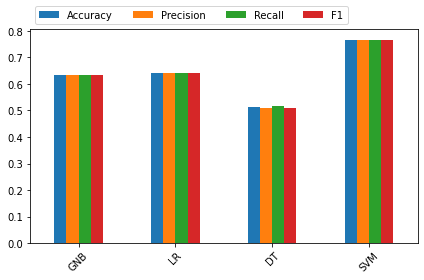

In [45]:
evaluateModels(models, X_train, y_train)

# T3.A - hard and soft voting

In [46]:
# get a voting ensemble of modelsVoting
def getVoting(hardOrSoft):
 # define the base modelsVoting
 # define the voting ensemble
  modelsVoting = getModelsList()

  # define the voting ensemble
  ensemble = VotingClassifier(estimators=modelsVoting, voting=hardOrSoft)
  return ensemble

In [47]:
def getModelsVoting(hardOrSoft):
  modelsVoting = getModelsDict()
  modelsVoting[hardOrSoft] = getVoting(hardOrSoft)
  return modelsVoting

In [48]:
def evaluateModelVoting(model, X, y):
 cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
 return scores

In [49]:
def votingView(hardOrSoft):
  modelsVoting = getModelsVoting(hardOrSoft)
  # evaluate the modelsVoting and store results
  results, names = list(), list()
  for name, model in modelsVoting.items():
    print("name:  " + name)
    scores = evaluateModelVoting(model, X, Y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
  # plot model performance for comparison
  pyplot.boxplot(results, labels=names, showmeans=True)
  pyplot.show()

Soft voting
name:  GNB
>GNB 0.640 (0.051)
name:  LR
>LR 0.653 (0.046)
name:  DT
>DT 0.519 (0.054)
name:  SVM
>SVM 0.783 (0.037)
name:  hard
>hard 0.710 (0.048)


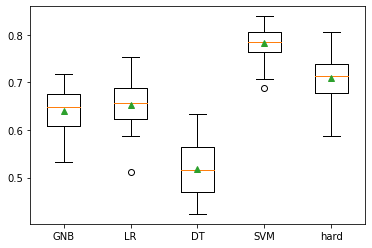

Hard voting
name:  GNB
>GNB 0.640 (0.051)
name:  LR
>LR 0.653 (0.046)
name:  DT
>DT 0.512 (0.048)
name:  SVM
>SVM 0.783 (0.037)
name:  soft
>soft 0.694 (0.037)


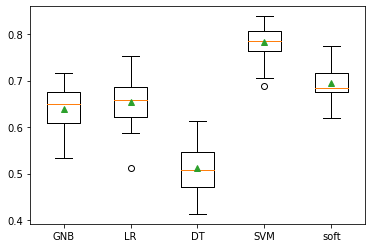

In [50]:
print("Soft voting")
votingView("hard")
print("Hard voting")
votingView("soft")

In [51]:
ensembleHard = getVoting("hard")
esembleSoft = getVoting("soft")
models['Hard'] = ensembleHard 
models['Soft'] = esembleSoft

# T3.A - stacking

In [52]:
def getBaseModelsList():
  baseModelsList = list()
  baseModelsList.append(('GNB', GaussianNB()))
  baseModelsList.append(('LR', LogisticRegression(C = 1, penalty = 'l2', solver ='saga', max_iter = 5000, tol = 0.001)))
  baseModelsList.append(('DT', DecisionTreeClassifier(criterion= "entropy", max_depth = None,  min_samples_leaf= 1)))

  return baseModelsList

In [53]:
# fit the blending ensemble
def fitEsemble(models, X_train, X_val, y_train, y_val):
  # fit all models on the training set and predict on hold out set
  meta_X = list()
  for name, model in models:
    # fit in training set
    model.fit(X_train, y_train)
    # predict on hold out set
    yhat = model.predict(X_val)
    # reshape predictions into a matrix with one column
    yhat = yhat.reshape(len(yhat), 1)
    # store predictions as input for blending
    meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
  meta_X = hstack(meta_X)
  # define blending model
  blender = SVC(C= 1.0, kernel= "rbf", gamma = "scale", probability = True, max_iter = 5000, tol = 0.05)

  # fit on predictions from base models
  blender.fit(meta_X, y_val)
  return blender

In [54]:
def predictEsemble(models, blender, X_test):
  # make predictions with base models
  meta_X = list()
  for name, model in models:
    # predict with base model
    yhat = model.predict(X_test)
    # reshape predictions into a matrix with one column
    yhat = yhat.reshape(len(yhat), 1)
    # store prediction
    meta_X.append(yhat)
    # create 2d array from predictions, each set is an input feature
  meta_X = hstack(meta_X)
  # predict
  return blender.predict(meta_X)

In [55]:
# create the base baseModels
baseModels = getBaseModelsList()
# train the blending ensemble
blender = fitEsemble(baseModels, X_train, X_test, y_train, y_test)
# make predictions on test set
yhat = predictEsemble(baseModels, blender, X_test)

In [56]:
models["Blender"] = blender

In [57]:
score = accuracy_score(y_test, yhat)
print('Blending Accuracy: %.3f' % score)

Blending Accuracy: 0.638


# T3.A random forest

In [58]:
randomForest = RandomForestClassifier()
n_estimators = [100, 200, 500]
min_samples_leaf = [5, 10]
criterion = ["gini", "entropy"]
hyperparameters = dict(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, criterion=criterion)

In [59]:
clf = GridSearchCV(randomForest, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X, Y)
print("Best n_estimators:", best_model.best_estimator_.get_params()["n_estimators"])
print("Best min_samples_leaf:", best_model.best_estimator_.get_params()["min_samples_leaf"])
print("Best criterion:", best_model.best_estimator_.get_params()["criterion"])

Best n_estimators: 200
Best min_samples_leaf: 5
Best criterion: entropy


In [60]:
models["RM"] = RandomForestClassifier(n_estimators=500, min_samples_leaf=5, criterion='entropy')

# T3 - b&c

Ranking of the models in terms of highest to lowest performanc is: joint SVM/Blender, Hard, Soft, LR, GNB and DT


         Accuracy  Precision    Recall        F1
GNB      0.634170   0.634170  0.634170  0.634170
LR       0.643170   0.643170  0.643170  0.643170
DT       0.507278   0.506830  0.516737  0.514926
SVM      0.767387   0.767387  0.767387  0.767387
Hard     0.712729   0.713621  0.710909  0.712269
Soft     0.689229   0.698278  0.692401  0.696476
Blender  0.767387   0.767387  0.767387  0.767387
RM       0.646804   0.653113  0.648155  0.653561


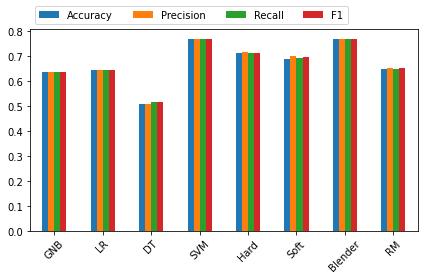

In [61]:
evaluateModels(models, X_train, y_train)

# T4.A Fit a multivariate linear regression model 

In [ ]:
Y = dfClean['target']

X = dfClean.drop("target", axis=1)
X = X.drop("class", axis=1)

In [ ]:
columnNames = list(X.columns)

In [ ]:
standardizer = StandardScaler()
X = standardizer.fit_transform(X)

In [ ]:
X = pd.DataFrame(data = X
             , columns = columnNames)

In [ ]:
def getPolynomialRegressionModel(X, Y):
  #define our polynomial model, with whatever degree we want
  degree=2
  # PolynomialFeatures will create a new matrix consisting of all polynomial combinations 
  # of the features with a degree less than or equal to the degree we just gave the model (2)
  polyModel = PolynomialFeatures(degree=degree)

  # transform out polynomial features
  polyXValues = polyModel.fit_transform(X)

  # let's fit the model
  polyModel.fit(polyXValues, Y)

  # we use linear regression as a base!!! ** sometimes misunderstood **
  regressionModel = LinearRegression()

  regressionModel.fit(polyXValues, Y)

  return regressionModel

# T4 B

Estimate and report on the R2 measure and the root mean squared error achieved using 3-
repetition, 5-fold cross validation

In [ ]:
def evaluateKFoldRSquaredAndRMSE(model, X_train, y_train):
  r2, rmse = {}, {}

  # print(SCORERS.keys())
  cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=2652124)
  
  r2Found = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv, n_jobs=-1)
  negativeRmseFound = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
  rmseFound = abs(negativeRmseFound)

  #performance result
  print('R2 measure: %.3f (%.3f)' % (mean(r2Found), std(r2Found)))
  print('Root mean squared error: %.3f (%.3f)' % (mean(rmseFound), std(rmseFound)))

In [ ]:
regressionModel = getPolynomialRegressionModel(X_train, y_train)
evaluateKFoldRSquaredAndRMSE(regressionModel, X_train, y_train)

R2 measure: 0.348 (0.011)
Root mean squared error: 1.459 (0.014)


# T5.A

Inside this task, you have to exploit the best classifier found among the eight options considered in T2 and T3
and the regressor resulting from T4. To this end, you have to load the following files:
- im x gg.txt (gg is the group number), contains the 36-component samples corresponding to each pixel of an
100 × 100 image, one row per sample;
- im y gg.txt (gg is the group number), contains the class label for the sample at the same row; and
- im t gg.txt (gg is the group number), contains the target value for the sample at the same row.

In [ ]:
dfX = pd.read_csv('im_x_03.csv')

In [ ]:
dfX.head(3)

,V01,V02,V03,V04,V05,V06,V07,V08,V09,V10,...,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36
0,10.43,5.09,11.08,30.06,6.08,4.52,3.63,15.21,2.10,13.03,...,11.74,29.36,37.80,12.59,16.45,4.41,28.76,47.35,10.19,11.54
1,13.59,3.55,9.21,40.17,8.49,4.85,5.61,11.75,5.45,7.49,...,12.89,27.59,53.65,12.86,19.61,2.43,33.54,45.36,6.00,6.94
2,6.18,4.02,14.18,35.36,17.57,14.89,3.31,14.85,2.86,9.79,...,17.11,31.33,59.14,13.30,14.34,4.15,49.11,27.97,6.15,12.03


In [ ]:
dfY = pd.read_csv('im_y_03.txt',names=["class"], header=None)
dfT = pd.read_csv('im_t_03.txt',names=["target"], header=None)

,target
0,0.379836
1,0.407861
2,0.427624


In [ ]:
dfY.head(3)
dfT.head(3)

,target
0,0.379836
1,0.407861
2,0.427624


(a) Using the best classifier, classify each pixel and report on the number of errors (i.e. pixels wrongly classified) and on the accuracy, precision, recall and F1 score.

In [ ]:
dfClassificationX = dfX.join(dfT)

In [ ]:
standardizer = StandardScaler()
dfClassificationX = standardizer.fit_transform(dfClassificationX)
dfClassificationX = pd.DataFrame(data = dfClassificationX
             , columns = columnNames)

In [ ]:
dfClassificationY = dfY

In [ ]:
n = findWantedKforPCA(dfClassificationX, 0.95)
print("number of features needed for 95% variance:  " + str(n))
pca = PCA(n_components=n)
principalComponents = pca.fit_transform(dfClassificationX)

pca.explained_variance_ratio_
print(sum(pca.explained_variance_ratio_))

dfClassificationX = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3', 'principal component 4','principal component 5','principal component 6','principal component 7','principal component 8','principal component 9','principal component 10',
                          'principal component 11','principal component 12','principal component 13', 'principal component 14', 'principal component 15','principal component 16','principal component 17', 'principal component 18', 
                          'principal component 19','principal component 20','principal component 21', 'principal component 22', 'principal component 23'])

dfClassificationX.tail()

number of features needed for 95% variance:  23
0.9654198766406277


,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,principal component 14,principal component 15,principal component 16,principal component 17,principal component 18,principal component 19,principal component 20,principal component 21,principal component 22,principal component 23
9995,-0.471179,-1.520258,0.939796,-1.796208,-0.023035,2.428056,-1.767592,1.985086,-0.755174,-0.011401,...,-0.752939,0.199908,0.008948,0.506596,0.601334,0.749235,-0.991206,-0.542979,-1.330580,-0.623072
9996,3.586683,-2.607055,0.532608,-2.049892,-1.448496,0.332515,-1.547568,-1.363036,3.509752,-0.003456,...,0.003231,0.332089,0.354353,-1.488028,-0.355637,-0.499920,-0.057105,0.461296,-1.162739,0.703826
9997,-0.004966,0.031870,0.848948,-4.846823,0.711109,-1.325963,1.017829,-2.433142,3.555270,-1.367719,...,2.070273,-0.575431,0.512608,-0.588621,-1.662459,-1.302737,1.162364,0.833714,-0.191739,0.778976
9998,-0.652404,-1.085401,1.484341,-1.678967,-2.430705,2.786592,0.210602,1.742559,0.458321,0.460769,...,-2.266833,0.979694,0.903370,-1.108529,1.786754,-0.498476,-2.208220,1.252023,-1.266911,-0.013522
9999,0.583902,2.548716,5.064278,-0.964191,1.236998,-0.134508,-0.185074,0.250289,0.357169,0.085725,...,0.633980,0.788878,-1.745538,-0.262944,1.222204,-0.047270,0.860966,0.292872,-0.647616,-0.591158


In [ ]:
SVM = SVC(C= 1.0, kernel= "rbf", gamma = "scale", probability = True, max_iter = 5000, tol = 0.05)
X_train, X_test, y_train, y_test = train_test_split(dfClassificationX,dfClassificationY,test_size = 0.2, random_state =0)

In [ ]:
evaluateModel(SVM, X_train, y_train)

Accuracy: 0.987 (0.004)
Precision: 0.987 (0.004)
Recall: 0.987 (0.004)
f1: 0.987 (0.004)


[array([0.99    , 0.986875, 0.986875, 0.9875  , 0.988125, 0.985625,
        0.994375, 0.98875 , 0.983125, 0.985   , 0.988125, 0.979375,
        0.990625, 0.985625, 0.991875]),
 array([0.99    , 0.986875, 0.986875, 0.9875  , 0.988125, 0.985625,
        0.994375, 0.98875 , 0.983125, 0.985   , 0.988125, 0.979375,
        0.990625, 0.985625, 0.991875]),
 array([0.99    , 0.986875, 0.986875, 0.9875  , 0.988125, 0.985625,
        0.994375, 0.98875 , 0.983125, 0.985   , 0.988125, 0.979375,
        0.990625, 0.985625, 0.991875]),
 array([0.99    , 0.986875, 0.986875, 0.9875  , 0.988125, 0.985625,
        0.994375, 0.98875 , 0.983125, 0.985   , 0.988125, 0.979375,
        0.990625, 0.985625, 0.991875])]

# T5.B

(b) Using the regressor, predict the target values and report on the root mean squared error. You do not need to use n-fold cross validation

In [ ]:
dfRegressionX = dfX
columnNamesX = list(dfX.columns)
dfRegressionX = standardizer.fit_transform(dfRegressionX)
dfRegressionX = pd.DataFrame(data = dfRegressionX
             , columns = columnNamesX)
dfRegressionY = dfT

In [ ]:
regressionModel = getPolynomialRegressionModel(dfRegressionX, dfRegressionY)
evaluateKFoldRSquaredAndRMSE(regressionModel, X_train, y_train)

R2 measure: 0.348 (0.011)
Root mean squared error: 1.459 (0.014)
